# **Setup**

**Imports**

In [1]:
# @title

import torch
import scipy
import numpy as np
import os
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader as DL
from torch.utils.data import TensorDataset as TData
import torch.optim as optim
from tqdm.auto import tqdm
from google.colab import files


In [5]:
import numpy as np
import pandas as pd
import torch
import scipy
from torch.utils.data import TensorDataset as TData
from torch.utils.data import DataLoader as DL
import matplotlib.pyplot as plt

In [2]:
# @title
import zipfile
import os

To run model, first make a new folder in the files tab to the left, naming it EEGData. Running the following code will process the data and set up the train and test dataloaders for you

In [18]:
import numpy as np
import pandas as pd

# Use np.load to read the .npy file
dataset = pd.read_csv("BCICIV_2a_all_patients.csv") # loading in the csv dataset with pandas
# If you want to convert it to a pandas DataFrame, you can do this:


In [19]:
# checks if cuda is available, then sets device to GPU
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
device # should say cuda if gpu is enabled

'cuda'

In [20]:

print(dataset)

        patient   time   label  epoch    EEG-Fz     EEG-0     EEG-1     EEG-2  \
0             1 -0.100  tongue      8 -1.681412  2.245496 -0.158350  1.163765   
1             1 -0.096  tongue      8  0.420417  0.587559  1.650510  0.970672   
2             1 -0.092  tongue      8  0.551365  1.499758  0.121302  2.859433   
3             1 -0.088  tongue      8  3.054916 -1.807238  1.843603  2.286812   
4             1 -0.084  tongue      8  2.506710 -2.453101  0.221178  0.127278   
...         ...    ...     ...    ...       ...       ...       ...       ...   
492043        9  0.684    foot    638  7.375522  4.646781  3.071135  4.665561   
492044        9  0.688    foot    638  7.268988  1.952357  5.503664  3.484809   
492045        9  0.692    foot    638  4.581222  3.463809  4.427226  4.752120   
492046        9  0.696    foot    638  3.504784  4.096355  2.960162  3.187401   
492047        9  0.700    foot    638  3.751144  0.436465  0.765116  0.064620   

           EEG-3     EEG-4 

In [21]:
dataset = dataset.drop(columns=['EEG-Fz','EEG-2', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16'])


new_order = ['patient', 'time', 'label', 'epoch', 'EEG-5', 'EEG-0', 'EEG-C3', 'EEG-9',
       'EEG-10', 'EEG-6', 'EEG-1', 'EEG-Cz', 'EEG-11', 'EEG-12',
      'EEG-7', 'EEG-3', 'EEG-4', 'EEG-C4', 'EEG-13', 'EEG-8']
dataset = dataset[new_order]

dataset.head() # first five rows

,patient,time,label,epoch,EEG-5,EEG-0,EEG-C3,EEG-9,EEG-10,EEG-6,EEG-1,EEG-Cz,EEG-11,EEG-12,EEG-7,EEG-3,EEG-4,EEG-C4,EEG-13,EEG-8
0,1,-0.100,tongue,8,3.299057,2.245496,3.928189,3.441785,0.305517,0.673606,-0.158350,0.972209,1.137473,-1.275763,-2.340592,-1.523659,-0.575267,-2.562196,-2.898359,0.758116
1,1,-0.096,tongue,8,3.838386,0.587559,2.514392,-0.071620,0.258909,1.798873,1.650510,1.316225,-1.448198,0.142472,0.347175,1.505904,0.891796,-1.827555,-1.968405,1.541586
2,1,-0.092,tongue,8,2.162693,1.499758,1.522294,-2.137938,-1.612096,-0.072132,0.121302,0.861236,-1.610218,-0.410173,2.577732,2.613414,4.636026,2.600268,-0.274957,2.649097
3,1,-0.088,tongue,8,2.078354,-1.807238,-1.980015,-5.249621,-2.672998,0.136497,1.843603,-1.029744,-3.452370,0.189081,4.446518,5.995872,6.651295,3.248351,1.593829,6.031554
4,1,-0.084,tongue,8,0.309444,-2.453101,-3.358299,-5.309546,-2.488783,-2.023038,0.221178,-2.163888,-3.707608,1.447515,4.337764,4.519931,6.249573,4.946238,4.268278,7.827097


In [22]:
# list of columns
print(dataset.columns, end='\n\n') # 12 eeg channels

# unique labels
print(dataset['label'].unique()) # 4 classes

# number of patients
print(dataset.patient.unique())

Index(['patient', 'time', 'label', 'epoch', 'EEG-5', 'EEG-0', 'EEG-C3',
       'EEG-9', 'EEG-10', 'EEG-6', 'EEG-1', 'EEG-Cz', 'EEG-11', 'EEG-12',
       'EEG-7', 'EEG-3', 'EEG-4', 'EEG-C4', 'EEG-13', 'EEG-8'],
      dtype='object')

['tongue' 'foot' 'right' 'left']
[1 2 3 4 5 6 7 8 9]


In [23]:
# only interested in rows where target is left or right hand in this tutorial for simplicity
binary_mi = dataset.loc[(dataset['label'] == 'left') | (dataset['label'] == 'right')]
binary_mi.label.unique() # check that our row filter worked

array(['right', 'left'], dtype=object)

In [24]:
# get time period and check that it is constant throughout dataframe
t0 = binary_mi.time.iloc[:-1] # get time points except last one
t1 = binary_mi.time.iloc[1:] # series offest by one, so starting at 2nd time point until last
t0.reset_index(drop=True, inplace=True)
t1.reset_index(drop=True, inplace=True)

print(t0 - t1) # subtracting the two series to get time differences between adjacent time points
const_diff = ((t0 - t1 < -0.0039) & (t0 - t1 > -0.0041)) # checking that they are all around -0.004
const_diff[const_diff != True] # getting just the rows where time difference wasn't around -0.004

0        -0.004
1        -0.004
2        -0.004
3        -0.004
4        -0.004
          ...  
260490   -0.004
260491   -0.004
260492   -0.004
260493   -0.004
260494   -0.004
Name: time, Length: 260495, dtype: float64


,time
200,False
401,False
602,False
803,False
1004,False
...,...
259490,False
259691,False
259892,False
260093,False


In [25]:
print((t0 - t1)[200])
binary_mi.iloc[200:, 2] # time discrepancy seems to be caused by label change

0.7999999999999999


,label
602,right
603,left
604,left
605,left
606,left
...,...
491842,right
491843,right
491844,right
491845,right


In [26]:
# don't care about time and epoch anymore
pruned_mi = binary_mi.drop(columns = ['time', 'epoch'])
pruned_mi.head()

,patient,label,EEG-5,EEG-0,EEG-C3,EEG-9,EEG-10,EEG-6,EEG-1,EEG-Cz,EEG-11,EEG-12,EEG-7,EEG-3,EEG-4,EEG-C4,EEG-13,EEG-8
402,1,right,-4.727450,-7.846816,-4.680500,-0.901954,1.939467,-1.142339,-6.412021,3.699157,2.611793,3.706669,3.794936,0.023902,1.723496,4.052222,3.466285,3.113220
403,1,right,-2.241655,-7.314146,-3.757205,-0.027487,3.302215,1.196972,-3.828569,0.960343,1.923760,2.139730,3.546356,0.312432,-0.771177,1.362236,2.143486,3.987687
404,1,right,1.904297,-3.558819,-0.587816,2.311824,3.004808,1.876127,-2.026367,-0.215971,-0.277945,0.523963,0.758714,-1.010367,-2.435772,-1.523062,-0.155874,4.032076
405,1,right,3.970614,-1.199533,2.943346,3.645720,3.508625,2.379944,-1.473722,-0.298091,0.274701,-1.169485,-1.423015,-1.873737,-2.078439,-3.655963,-2.972369,1.069097
406,1,right,6.372070,-0.604718,4.417067,4.826472,5.031175,3.756010,-0.585937,-0.777494,-0.155874,-1.648888,-1.560622,-2.353140,-4.169171,-5.160757,-4.672476,-1.754056


In [27]:
# get unique patients and labels
patients = binary_mi.patient.unique() # 1-9
labels = binary_mi.label.unique()     # left and right

In [28]:
left_hand = []
right_hand = []

# for each patient, get patient readings, convert to numpy array, and add
# to list corresponding to target (left or right)
for patient in patients:
  left_df = pruned_mi[(pruned_mi['patient'] == patient) & (pruned_mi['label'] == 'left')]
  right_df = pruned_mi[(pruned_mi['patient'] == patient) & (pruned_mi['label'] == 'right')]

  left_hand.append(left_df.iloc[:, 2:].to_numpy().T)
  right_hand.append(right_df.iloc[:, 2:].to_numpy().T)

right_hand[0].shape # shows shape of each list element

(16, 14472)

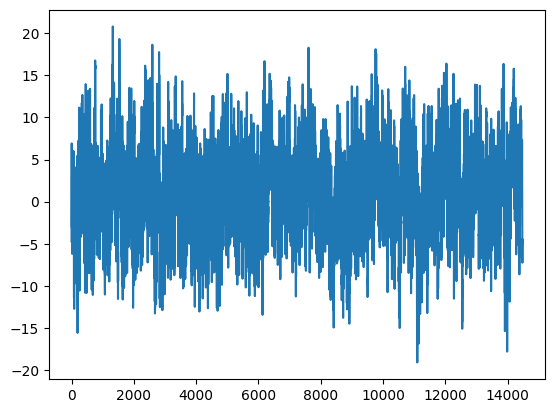

In [29]:
plt.plot(right_hand[0][0]) # visualizing first channel of first patient thinking of right hand motion

In [30]:
# get sequence length/length of each signal
left_len = left_hand[0].shape[1]
right_len = right_hand[0].shape[1]
# portion of sequence used for validation/testing set
left_eval_len = int(0.4 * left_hand[0].shape[1])
right_eval_len = int(0.4 * right_hand[0].shape[1])

# select random starting indexes for sub-sequences for validation and testing sets
left_hand_partition = np.random.randint(0, left_len - left_eval_len, len(left_hand))
right_hand_partition = np.random.randint(0, right_len - right_eval_len, len(right_hand))

# initialize lists to hold respective signals
left_train = []
left_val = []
left_test = []
right_train = []
right_val = []
right_test = []

# create training, validation, and testing sets for left hand signals
for i, num in enumerate(left_hand_partition):
  # get ending index of subsequence being cropped for validation and testing sets
  upper_end = num + left_eval_len
  # add portion of sequence excluding num:upper_end (portion used for evaluation)
  left_train.append(left_hand[i][:, list(range(num)) + list(range(upper_end, left_len))])
  # first half of subsequence used for validation
  left_val.append(left_hand[i][:, num:num+(left_eval_len//2)])
  # second half used for test set
  left_test.append(left_hand[i][:, num+(left_eval_len//2):num + left_eval_len])

# create training, validation, and testing sets for right hand signals
for i, num in enumerate(right_hand_partition):
  # get ending index of subsequence being cropped for validation and testing sets
  upper_end = num + right_eval_len
  # add portion of sequence excluding num:upper_end (portion used for evaluation)
  right_train.append(right_hand[i][:, list(range(num)) + list(range(upper_end, right_len))])
  # first half of subsequence used for validation
  right_val.append(right_hand[i][:, num:num+(right_eval_len//2)])
  # second half used for test set
  right_test.append(right_hand[i][:, num+(right_eval_len//2):num + right_eval_len])

In [31]:
# function to bandpass filter signals
def bandpass_filter(signal, crit_freq = [5, 40], sampling_freq = 125):
  order = 4
  b, a = scipy.signal.butter(order, crit_freq, btype = 'bandpass', fs = sampling_freq)
  processed_signal = scipy.signal.filtfilt(b, a, signal, 1)
  return processed_signal

# segment a signal using sliding window technique, specifying sample frequency, window size, and window shift
def segmentation(signal, sampling_freq=125, window_size=1, window_shift=0.016):
  w_size = int(sampling_freq * window_size)
  w_shift = int(sampling_freq * window_shift)
  segments = []
  i = 0
  while i + w_size <= signal.shape[1]:
    segments.append(signal[:, i: i + w_size])
    i += w_shift
  return segments

# apply preprocessing steps in sequence to each signal
def preprocess(signals, crit_freq=[5,35], fs=250):
  preprocessed = []
  for signal in signals:
    # perform bandpass filter on each signal
    filtered_signal = bandpass_filter(signal, crit_freq, fs)
    # channel-wise z-score normalization
    normed_signal = (filtered_signal - filtered_signal.mean(1, keepdims=True)) / filtered_signal.std(1, keepdims=True)
    # segmentation of signals
    segments = segmentation(normed_signal, fs)
    # add signals to list
    preprocessed.extend(segments)
  return preprocessed

In [32]:
# generate preprocessed segments for training, validation, and testing
train_left = preprocess(left_train)
val_left = preprocess(left_val)
test_left = preprocess(left_test)
train_right = preprocess(right_train)
val_right = preprocess(right_val)
test_right = preprocess(right_test)

# print number of samples corresponding to left and right hand targets
print(f'left samples: {len(train_left) + len(val_left) + len(test_left)}, right samples: {len(train_right) + len(val_right) + len(test_right)}')
# print shape of each sample
print(f'segment shape: {train_left[0].shape}')

left samples: 30897, right samples: 30897
segment shape: (16, 250)


In [33]:
# combine left and right signals to generate signal training, validation, and testing set
train_eeg = train_left + train_right
val_eeg = val_left + val_right
test_eeg = test_left + test_right
train_labels = [0 for i in range(len(train_left))] + [1 for i in range(len(train_right))]
val_labels = [0 for i in range(len(val_left))] + [1 for i in range(len(val_right))]
test_labels = [0 for i in range(len(test_left))] + [1 for i in range(len(test_right))]

In [34]:
# create torch tensor of zeros to hold data
train_eeg_tensor = torch.zeros((len(train_eeg), train_eeg[0].shape[0], train_eeg[0].shape[1]))
valid_eeg_tensor = torch.zeros((len(val_eeg), val_eeg[0].shape[0], val_eeg[0].shape[1]))
test_eeg_tensor = torch.zeros((len(test_eeg), test_eeg[0].shape[0], test_eeg[0].shape[1]))

# add each sample in train, validation, and test lists to appropriate tensor at correct index
for i in range(len(train_eeg)):
  tens = torch.from_numpy(train_eeg[i].copy())
  train_eeg_tensor[i] = tens
for i in range(len(val_eeg)):
  tens = torch.from_numpy(val_eeg[i].copy())
  valid_eeg_tensor[i] = tens
for i in range(len(test_eeg)):
  tens = torch.from_numpy(test_eeg[i].copy())
  test_eeg_tensor[i] = tens

# create zero tensor for one hot encoded labels
#train_labels should now equal 12
train_label_tensor = torch.zeros(len(train_labels), 2)
valid_label_tensor = torch.zeros(len(val_labels), 2)
test_label_tensor = torch.zeros(len(test_labels), 2)


# add labels to tensor at correct index
for i in range(len(train_labels)):
  label = train_labels[i]
  train_label_tensor[i][label] = 1
for i in range(len(val_labels)):
  label = val_labels[i]
  valid_label_tensor[i][label] = 1
for i in range(len(test_labels)):
  label = test_labels[i]
  test_label_tensor[i][label] = 1

# convert input, target tensors to Tensor Dataset from torch
train_ds = TData(train_eeg_tensor, train_label_tensor)
valid_ds = TData(valid_eeg_tensor, valid_label_tensor)
test_ds = TData(test_eeg_tensor, test_label_tensor)
# create dataloaders to hold batched data (batch size chosen was 64)
train_dl = DL(train_ds, batch_size=64, shuffle= True, drop_last = True)
valid_dl = DL(valid_ds, batch_size=64, shuffle= True, drop_last = True)
test_dl = DL(test_ds, batch_size=64, shuffle = True, drop_last = True)

for i, (data, label) in enumerate(train_ds):
  print(f"Sample {i + 1}:")
  print(f"Data shape: {data.shape}")
  print(data[0])
  print(f"Label shape: {label.shape}")

Streaming output truncated to the last 5000 lines.
        -1.3306, -1.2735, -1.0978, -0.8261, -0.4988, -0.1663,  0.1225,  0.3326,
         0.4514,  0.4916,  0.4876,  0.4814,  0.5030,  0.5501,  0.5812,  0.5299,
         0.3361, -0.0221, -0.5132, -1.0600, -1.5637, -1.9297, -2.0867, -1.9935,
        -1.6399, -1.0464, -0.2675,  0.6052,  1.4524,  2.1565,  2.6425,  2.9048,
         2.9936,  2.9666,  2.8406,  2.5838,  2.1525,  1.5407,  0.7989,  0.0094,
        -0.7583, -1.4709, -2.1186, -2.6807, -3.1045, -3.3215, -3.2925, -3.0513,
        -2.7064, -2.3918, -2.1899, -2.0754, -1.9213, -1.5676, -0.9144,  0.0183,
         1.0960,  2.1306,  2.9540,  3.4665,  3.6475,  3.5372,  3.2043,  2.7173,
         2.1318,  1.4995,  0.8824,  0.3520, -0.0329, -0.2541, -0.3453, -0.3759,
        -0.4178, -0.5147, -0.6681, -0.8417, -0.9812, -1.0393, -1.0005, -0.8938,
        -0.7836, -0.7397, -0.8008, -0.9515, -1.1260, -1.2360, -1.2110, -1.0341,
        -0.7512, -0.4460, -0.1911, -0.0071,  0.1423,  0.3205,  0.5729

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['EEGMouse_Nathan_3_54_1329.npy', 'EEGMouse_Nathan_1_29_867.npy', 'EEGMouse_Nathan_1_26_799.npy', 'EEGMouse_Nathan_3_19_684.npy', 'EEGMouse_Nathan_1_13_560.npy', 'EEGMouse_Nathan_1_16_624.npy', 'EEGMouse_Nathan_3_19_674.npy', 'EEGMouse_Nathan_3_4_370.npy', 'EEGMouse_Nathan_3_56_1377.npy', 'EEGMouse_Nathan_1_50_1246.npy', 'EEGMouse_Nathan_3_47_1174.npy', 'EEGMouse_Nathan_1_52_1290.npy', 'EEGMouse_Nathan_1_27_817.npy', 'EEGMouse_Nathan_1_57_1398.npy', 'EEGMouse_Nathan_3_37_1028.npy', 'EEGMouse_Nathan_3_19_680.npy', 'EEGMouse_Nathan_3_22_730.npy', 'EEGMouse_Nathan_3_40_1063.npy', 'EEGMouse_Nathan_3_36_994.npy', 'EEGMouse_Nathan_1_37_1017.npy', 'EEGMouse_Nathan_1_5_385.npy', 'EEGMouse_Nathan_3_35_976.npy', 'EEGMouse_Nathan_3_10_495.npy', 'EEGMouse_Nathan_3_7_451.npy', 'EEGMouse_Nathan_3_32_924.npy', 'EEGMouse_Nathan_1_30_885.npy', 'EEGMouse_Nathan_3_32_922.npy', 

<ipython-input-21-3bad1c063c7e>:92: RuntimeWarning: invalid value encountered in divide
  normed_sig = (filtered_sig - np.mean(filtered_sig, 1, keepdims=True)) / np.std(filtered_sig, 1, keepdims=True) # standard scaling


EEGMouse_Nathan_1_51_1262.npy
EEGMouse_Nathan_1_50_1240.npy
EEGMouse_Nathan_1_47_1173.npy


In [ ]:
b, l = next(iter(train_dl))

Below is the model code, which you have already gone through

In [39]:
# @title
class Squash(nn.Module):
    def __init__(self, eps=1e-20):
        super(Squash, self).__init__()
        self.eps = eps

    def forward(self, x):
        norm = torch.linalg.norm(x, ord=2, dim=-1, keepdim=True)
        coef = 1 - 1 / (torch.exp(norm) + self.eps)
        unit = x / (norm + self.eps)
        return coef * unit

class Routing(nn.Module):
    def __init__(self, groups, in_dims, out_dims):
        super(Routing, self).__init__()
        N0, D0 = in_dims
        N1, self.D1 = out_dims
        self.W = nn.Parameter(torch.Tensor(groups, N1, N0, D0, self.D1))
        nn.init.kaiming_normal_(self.W)
        self.b = nn.Parameter(torch.zeros(groups, N1, N0, 1))
        self.squash = Squash()

    def forward(self, x):

        u = torch.einsum('...gni,gknid->...gknd', x, self.W) # shape: (B, G, N1, N0, D1)

        c = torch.einsum("...ij,...kj->...i", u, u) # shape: (B, N1, N0)

        c = c[..., None]  # (B, N1, N0, 1) for bias broadcasting
        c = c / torch.sqrt(torch.tensor(self.D1).float())  # stabilize
        c = torch.softmax(c, axis=1) + self.b

        ## new capsules
        s = torch.sum(u * c, dim=-2)

        return self.squash(s)


class ReconstructionNet(nn.Module):
    def __init__(self, input_size=(1, 28, 28), num_classes=2, num_capsules=64):
        super(ReconstructionNet, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(in_features=num_capsules * num_classes, out_features=512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, np.prod(input_size) * 2)
        self.relu = nn.ReLU()
        self.reset_parameters()

    def reset_parameters(self):
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc1.weight, gain=gain)
        nn.init.xavier_normal_(self.fc2.weight, gain=gain)
        nn.init.xavier_normal_(self.fc3.weight, gain=gain)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(x.size(0), 2, *self.input_size).squeeze(1)
        complex_x = torch.complex(x[:, 0], x[:, 1]) # create complex tensor to reflext fourier transform
        return complex_x


class CapsMask(nn.Module):
    def __init__(self):
        super(CapsMask, self).__init__()

    def forward(self, x, y_true=None):
        if y_true is not None:  # training mode
            mask = y_true
        else:  # testing mode
            # convert list of maximum value's indices to one-hot tensor
            temp = torch.sqrt(torch.sum(x**2, dim=-1))
            mask = F.one_hot(torch.argmax(temp, dim=1), num_classes=temp.shape[1])

        masked = x * mask.unsqueeze(-1)

        return masked.view(x.shape[0], -1)  # reshape


class CapsLen(nn.Module):
    def __init__(self, eps=1e-7):
        super(CapsLen, self).__init__()
        self.eps = eps

    def forward(self, x):
        return torch.sqrt(
            torch.sum(x**2, dim=-1) + self.eps
        )  # (batch_size, num_capsules)


In [35]:
# @title
class EEGCapsNet(nn.Module):
    def __init__(self, input_size=(1, 16, 192), num_classes=2):
        super(EEGCapsNet, self).__init__()
        self.channelCapsTemporal_1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=128, kernel_size=(1,64), groups=16, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,input_size[2]-63), groups=128), # collapse to 1 point
            #nn.Dropout(p=0.3)
        )
        self.channelCapsTemporal_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=128, kernel_size=(1, 24), groups=16, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,input_size[2]-23), groups=128), # collapse to 1 point
            #nn.Dropout(p=0.3)
        )
        # channel caps will eventually be transformed from 8x4 capsules to 4x8 higher level capsules

        self.channelRouting = Routing(16, (8, 4), (4, 8))
        self.channelShrink = Routing(8, (8, 8), (4, 8))
        self.channelDeepSuper = Routing(1, (64, 8), (2, 32))
        self.channel_align = Routing(16, (4, 8), (1, 8))

        self.localCapsSpatial_1 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=(2, 36), groups=8, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, input_size[2]-35), groups=64), # collapse to 1 point
            #nn.Dropout(p=0.3)
        )

        self.localCapsSpatial_2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=(2, 16), groups=8),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, input_size[2]-15), groups=64), # collapse to 1 point
            nn.Dropout(p=0.3)
        )

        self.localRouting = Routing(8, (8, 4), (4, 8))
        self.localShrink = Routing(8, (8, 8), (4, 16))
        self.localRegion = Routing(4, (8, 16), (4, 16))
        self.localDeepSuper = Routing(1, (32, 8), (2, 64))
        self.local_align = Routing(8, (4, 8), (2, 8))

        # local spatial caps will be transformed from 8x4 capsules to 8x8 higher level capsules
        # local caps will be 16x8 (with addition from channel caps) this will be reduced to 8x8


        self.regionCapsSpatial_1 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=(4, 24), groups=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, input_size[2]-23), groups=32) # collapse to 1 point
        )

        self.regionCapsSpatial_2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=(4, 32), groups=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, input_size[2]-31), groups=32) # collapse to 1 point
        )

        # region caps will be transformed from 8x4 capsules to 16x8 higher level capsules
        # region caps will be 32x8 (with addition from local caps) this will be reduced to 16x8

        self.regionRouting = Routing(4, (8, 4), (4, 16))
        self.regionShrink = Routing(4, (8, 16), (4, 16))
        self.regionHemi = Routing(2, (8, 16), (4, 16))
        self.regionDeepSuper = Routing(1, (16, 16), (2, 64))
        self.region_align = Routing(4, (4, 16), (4, 8))

        self.hemiCapsSpatial_1 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=16, kernel_size=(8, 30), groups=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, input_size[2]-29), groups=16) # collapse to 1 point
        )

        self.hemiCapsSpatial_2 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=16, kernel_size=(8, 60), groups=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, input_size[2]-59), groups=16) # collapse to 1 point
        )

        # hemi caps will be transformed from 8x4 capsules to 32x8 higher level capsules
        # hemi caps will be 64x8 (with addition from region caps) this will be reduced to 32x8

        self.hemiRouting = Routing(2, (8, 4), (4, 16))
        self.hemiShrink = Routing(2, (8, 16), (4, 16))
        self.hemi_align = Routing(2, (4, 16), (8, 8))

        self.out = Routing(1, (64, 8), (num_classes, 64)) #changed from (1, (8, 16), (num_classes, 64))
        self.generator = ReconstructionNet(input_size, num_classes)
        self.channel_generator = ReconstructionNet(input_size, num_classes, num_capsules=32)
        self.local_generator = ReconstructionNet(input_size, num_classes, num_capsules=64)
        self.region_generator = ReconstructionNet(input_size, num_classes, num_capsules=64)
        self.mask = CapsMask()
        self.capsLen = CapsLen()


    def forward(self, x, y_true=None, mode='train'):
        x = x.permute(0, 2, 1, 3)
        data = x
        x1 = self.channelCapsTemporal_1(data).view(data.size(0), 16, 16)
        x2 = self.channelCapsTemporal_2(data).view(data.size(0), 16, 16)
        channels = torch.cat((x1, x2), dim=2).view(data.size(0), 16, 8, 4)
        channels = self.channelRouting(channels) #shape (16, 4, 8)
        channelsAlign = self.channel_align(channels).view(data.size(0), 1, 16, 8)
        deep_channels = self.channelDeepSuper(channels.view(data.size(0), 1, 64, 8))
        #new_locals = self.channelShrink(channels.view(data.size(0), 8, 8, 8))

        x1 = self.localCapsSpatial_1(data.view(data.size(0), 8, 2, 192)).view(data.size(0), 8, 16)
        x2 = self.localCapsSpatial_2(data.view(data.size(0), 8, 2, 192)).view(data.size(0), 8, 16)
        local = torch.cat((x1, x2), dim=2).view(data.size(0), 8, 8, 4)
        local = self.localRouting(local) #shape (8, 4, 8)
        localsAlign = self.local_align(local).view(data.size(0), 1, 16, 8)
        deep_locals = self.localDeepSuper(local.view(data.size(0), 1, 32, 8))

        #local = torch.cat((local, new_locals), dim=2)
        #local = self.localShrink(local)
        #new_regions = self.localRegion(local.view(data.size(0), 4, 8, 16))

        x1 = self.regionCapsSpatial_1(data.view(data.size(0), 4, 4, 192)).view(data.size(0), 4, 16)
        x2 = self.regionCapsSpatial_2(data.view(data.size(0), 4, 4, 192)).view(data.size(0), 4, 16)
        regions = torch.cat((x1, x2), dim=2).view(data.size(0), 4, 8, 4)
        regions = self.regionRouting(regions) #shape (4, 4, 16)
        regionsAlign = self.region_align(regions).view(data.size(0), 1, 16, 8)
        deep_regions = self.regionDeepSuper(regions.view(data.size(0), 1, 16, 16))
        #regions = torch.cat((regions, new_regions), dim=2)
        #regions = self.regionShrink(regions)
        #new_hemis = self.regionHemi(regions.view(data.size(0), 2, 8, 16))

        x1 = self.hemiCapsSpatial_1(data.view(data.size(0), 2, 8, 192)).view(data.size(0), 2, 16)
        x2 = self.hemiCapsSpatial_2(data.view(data.size(0), 2, 8, 192)).view(data.size(0), 2, 16)
        hemis = torch.cat((x1, x2), dim=2).view(data.size(0), 2, 8, 4)
        hemis = self.hemiRouting(hemis) #shape (2, 4, 16)
        hemisAlign = self.hemi_align(hemis).view(data.size(0), 1, 16, 8)
        #hemisDeep = self.hemiDeepSuper(hemis.view(data.size(0), 1, 64, 8))
        #hemis = torch.cat((hemis, new_hemis), dim=2)
        #hemis = self.hemiShrink(hemis).view(data.size(0), 1, 8, 16)

        #First trying with only one layer between convolution and output
        #Essentially no layer combining and of the separate CNN information

        concatenated = torch.cat((channelsAlign, localsAlign, regionsAlign, hemisAlign), dim=2)
        out = self.out(concatenated)


        #out = self.out(hemis)
        out = out.squeeze(1)

        pred = self.capsLen(out)

        if mode == "train":
            masked = self.mask(out, y_true)
            deep_channels = deep_channels.squeeze(1)
            deep_locals = deep_locals.squeeze(1)         #removing these to also remove residuals
            deep_regions = deep_regions.squeeze(1)
            masked_channels = self.mask(deep_channels, y_true)
            masked_locals = self.mask(deep_locals, y_true)
            masked_regions = self.mask(deep_regions, y_true)
        elif mode == "eval":
            masked = self.mask(out)
            x = self.generator(masked)
            return pred, x
        elif mode == "test":
            return pred
        x = self.generator(masked)
        x_channels = self.channel_generator(masked_channels)
        x_locals = self.local_generator(masked_locals)
        x_regions = self.region_generator(masked_regions)
        pred_channels = self.capsLen(deep_channels)
        pred_locals = self.capsLen(deep_locals)
        pred_regions = self.capsLen(deep_regions)


        return pred, x, pred_regions, x_regions, pred_locals, x_locals, pred_channels, x_channels

# **Training**

Below is the custom loss function for training the model

In [36]:
# @title
class MarginLoss(nn.Module):
    def __init__(self, m_pos=0.9, m_neg=0.1, lambda_=0.5):
        super(MarginLoss, self).__init__()
        self.m_pos = m_pos
        self.m_neg = m_neg
        self.lambda_ = lambda_

    def forward(self, targets, digit_probs):
        assert targets.shape is not digit_probs.shape
        present_losses = (
            targets * torch.clamp_min(self.m_pos - digit_probs, min=0.0) ** 2
        )
        absent_losses = (1 - targets) * torch.clamp_min(
            digit_probs - self.m_neg, min=0.0
        ) ** 2
        losses = present_losses + self.lambda_ * absent_losses
        return torch.mean(torch.sum(losses, dim=1))


class ReconstructionLoss(nn.Module):
    def forward(self, reconstructions, input_images):
        if reconstructions[0].dtype not in [torch.float32, torch.float64]:
            magnitude_recon = torch.abs(reconstructions)
            magnitude_input = torch.abs(input_images)
            phase_recon = torch.angle(reconstructions)
            phase_input = torch.angle(input_images)
            return torch.nn.MSELoss(reduction="mean")(magnitude_recon, magnitude_input) + torch.nn.MSELoss(reduction="mean")(phase_recon, phase_input)
        return torch.nn.MSELoss(reduction="mean")(reconstructions, input_images)


class TotalLoss(nn.Module):
    def __init__(self, m_pos=0.9, m_neg=0.1, lambda_=0.5, recon_factor=0.0005):
        super(TotalLoss, self).__init__()
        self.margin_loss = MarginLoss(m_pos, m_neg, lambda_)
        self.recon_loss = ReconstructionLoss()
        self.recon_factor = recon_factor

    def forward(self, input_images, targets, reconstructions, digit_probs):
        margin = self.margin_loss(targets.squeeze(), digit_probs)
        recon = self.recon_loss(reconstructions, input_images)
        return margin + self.recon_factor * recon


Run this training loop. It may take a while even with the T4 Runtime!

In [37]:
!pip install --upgrade sympy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 64.7 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cud

In [51]:
print(train_ds[0][0].shape)

torch.Size([16, 250])


In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
deep_super_weights = [1/(1.5**i) for i in range(4)]
deep_super_weights = deep_super_weights / np.sum(deep_super_weights)
model = EEGCapsNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
criterion = TotalLoss()
num_epochs = 10


train_losses = []
val_losses = []
accs = []
max_acc = 0
for epoch in range(num_epochs):
    model.train()
    pbar_batch = tqdm(range(len(train_dl)))
    total_loss = 0
    for batch, (data, labels) in enumerate(train_dl):
        correct_train = 0
        total_train = 0
        x_fft = torch.fft.fft(data, dim=-1).to(device)
        optimizer.zero_grad()
        data = data.unsqueeze(1).to(device)
        labels = labels.to(device)
        outs = model(data)
        full_loss = 0
        for k in range(0, 8, 2):
            loss = criterion(x_fft, labels, outs[k+1], outs[k])
            loss *= deep_super_weights[k // 2]
            full_loss += loss
        full_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 5)
        optimizer.step()
        total_loss += full_loss.item()
        predicted = torch.argmax(outs[0], -1)
        labels = torch.argmax(labels, -1)
        correct_train += (predicted == labels).float().sum().item()
        total_train += labels.shape[0]
        pbar_batch.set_description(f"Batch {batch + 1}    loss={total_loss / (batch + 1):0.4f}      accuracy={correct_train/total_train:04f}")
        pbar_batch.update(1)
    pbar_batch.close()
    train_losses.append(total_loss / len(train_dl))
    total_val_loss = 0.0
    total_accuracy = 0.0
    # set model to evaluation mode, which changes the behavior
    # of some layers like dropout and batch normalization
    model.eval()
    with torch.no_grad():
        pbar = tqdm(total=len(valid_dl))
        for j, (x, y) in enumerate(valid_dl):
            x = x.float().cuda()
            y = y.cuda()
            x = x.unsqueeze(1)
            outs = model(x, mode='eval')
            pred = outs[0]
            img = outs[1]
            y = y.squeeze(1)
            x_fft = torch.fft.fft(x, dim=-1)
            loss = criterion(x_fft, y, img, pred)
            total_val_loss += loss.item()
            predicted = torch.argmax(pred, -1)
            labels = torch.argmax(y, -1)
            accuracy = (predicted == labels).float().mean().item()
            total_accuracy += accuracy
            pbar.set_description(f"val loss={total_val_loss / (j + 1):0.4f}    val acc={total_accuracy / (j + 1):0.4f}")
            pbar.update(1)
        pbar.close()
        val_losses.append(total_val_loss/len(valid_dl))
        accs.append(total_accuracy/len(valid_dl))
    # save model if accuracy is best seen
    if accs[-1] > max_acc:
      # dictionary with model state dict, optimizer state dict, and best accuracy
      checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'best_acc': accs[-1]}
      # save dictionary to specified file path if it exists or create new one otherwise
      torch.save(checkpoint, 'SepConv2.pth.tar')
      print('Model Saved')
      max_acc = accs[-1]
#pbar_epoch.close()

AttributeError: 'TensorDataset' object has no attribute 'size'

In [ ]:

plt.figure()
plt.plot(train_losses, label = 'train loss')
plt.plot(val_losses, label = 'val loss')
plt.legend()
plt.ylabel('Categorical Crossentropy')
plt.xlabel('Epoch')
plt.title('Loss over Epochs')


plt.figure()
plt.plot(accs)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

Interpretability


In [ ]:
!pip install captum
from captum.attr import LayerGradCam, LayerAttribution

def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
conductance = LayerConductance(model, model.out)
#test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
#conductance_vals = conductance.attribute(data.to(device), target=1).detach().numpy()
#visualize_importances(range(12),np.mean(cond_vals, axis=0),title="Average Neuron Importances", axis_title="Neurons")


# Assuming 'data' is your EEG input tensor
layer_gradcam = LayerGradCam(model, model.out)

attr = layer_gradcam.attribute(data.to(device), target=1, additional_forward_args=(labels.to(device), 'test'))
attr = attr.squeeze()

In [ ]:
# Assuming 'attr' contains the attributions and has shape (channels, time)
attr_abs = torch.abs(attr) # taking the absolute values
attr_mean = torch.mean(attr_abs, dim=1) #Averaging over the channels to represent the attributions as a single scalar value per input data point.
# assuming attr_mean has shape (batch_size, height, width)
plt.plot(attr_mean.cpu().detach().numpy())
plt.xlabel('Data Point Index')
plt.ylabel('Attribution')
plt.title('LayerGradCAM Attributions')


#INPROGRESS: get the color key to work
# Get the colormap
cmap = plt.cm.get_cmap('viridis')

# Define the number of color patches in the key
num_patches = 5

# Generate color patches and value ranges
values = np.linspace(attr_mean.min().item(), attr_mean.max().item(), num_patches)
colors = cmap(np.linspace(0, 1, num_patches))

# Create a custom legend with color patches and labels
patches = [
    plt.Rectangle((0, 0), 1, 1, color=colors[i], label=f'{values[i]:.2f} - {values[i+1]:.2f}' if i < num_patches - 1 else f'{values[i]:.2f}+')
    for i in range(num_patches)
]

plt.legend(handles=patches, loc='best', title='Attribution Values')

plt.show()
# for i in range(attr_mean.shape[0]):
#     plt.figure()
#     plt.imshow(attr_mean[i].cpu().detach().numpy(), cmap='viridis', aspect='auto', interpolation='nearest')
#     plt.colorbar(label='Attribution')
#     plt.xlabel('Time')
#     plt.ylabel('Channels')
#     plt.title(f'LayerGradCAM Attributions for Sample {i}')
#     plt.show()
